In [2]:
import torchvision.transforms as transforms
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

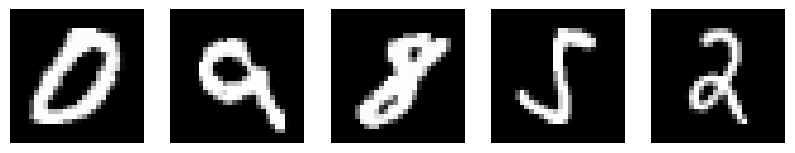

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

examples = iter(train_loader)
images, _ = next(examples)
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()


In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, 16)
        self.fc_logvar = nn.Linear(32, 16)
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 128), nn.ReLU(),
            nn.Linear(128, 28*28), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [5]:
def loss_function(x, x_recon, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [6]:
def train(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for x, _ in train_loader:
            x = x.view(-1, 28*28)

            optimizer.zero_grad()

            x_rec, mu, log_var = model(x)
            loss = loss_function(x, x_rec, mu, log_var)
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1)

In [7]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [8]:
train(model, optimizer, epochs=10)

	Epoch 1
	Epoch 2
	Epoch 3
	Epoch 4
	Epoch 5
	Epoch 6
	Epoch 7
	Epoch 8
	Epoch 9
	Epoch 10


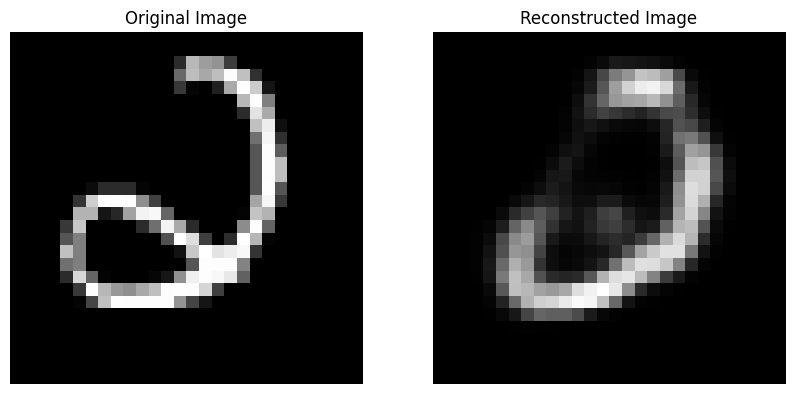

In [22]:
image, _ = next(iter(test_loader))

image = image.view(-1, 28*28)

model.eval()

with torch.no_grad():
    reconstructed_image, _, _ = model(image)

reconstructed_image = reconstructed_image.view(1, 28, 28)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image.view(28, 28).squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_image.squeeze(), cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()


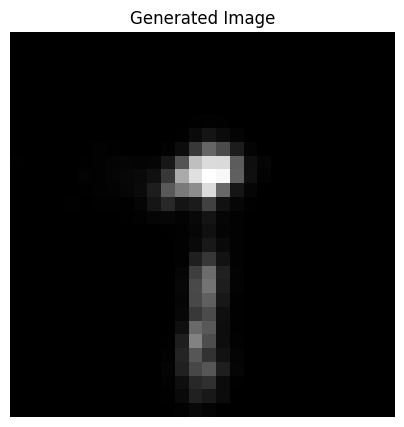

In [30]:
with torch.no_grad():
    noise = torch.randn(1, 16) 
    generated_images = model.decoder(noise)

generated_images = generated_images.view(1, 28, 28)

image = generated_images.squeeze(0) 

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image, cmap='gray')
ax.set_title('Generated Image')
ax.axis('off')
plt.show()